In [25]:
import csv
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../Lib/PythonML')

from linear import Linear
from multicouche import MLP
from svm import SVM 
from random import randrange
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D

In [26]:
labels = ['guitare','saxo', 'piano']
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
train_path = '../Dataset/Train/Fourier'
validation_path = '../Dataset/Test/Fourier'

# Fourier

In [27]:
frequency_max = 8000
frequency_precision = 2

In [28]:
def getCsvData(path):
    with open(path, newline='\n') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        data = [] 
        count = 0
        #0,1 -> 0 2,3 -> 1 4,5 -> 2
        for row in reader:
            if len(data) == (frequency_max * 2) / frequency_precision:
                break
            if count % frequency_precision != 0:
                count += 1
                continue
    
            frequency = float(row[0])
            if frequency > frequency_max:
                break
            if int(frequency) * 2 + 1 < count:
                continue
            count += 1
            data.append([float(row[0]), float(row[1])])
        return data

def importData(path, label_number = len(labels), max_by_label = -1):
    data = []
    label = []
    if label_number > len(labels):
        label_number = len(labels)
    for i in range(label_number):
        data_count_by_label = 0
        directory_path = os.path.join(path, labels[i])
        for r, _, f in os.walk(directory_path):
            for file in f:
                if data_count_by_label == max_by_label and max_by_label != -1:
                    break
                
                data_buff = getCsvData(os.path.join(directory_path, file))
                if len(data_buff) == (frequency_max * 2) / frequency_precision:
                    data.append(data_buff)
                    if i == 0 and label_number == 2:
                        label.append(-1)
                    else:
                        label.append(i)
                    data_count_by_label += 1

    return (np.array(data, dtype='float64'), np.array(label, dtype='float64'))

def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

def test_linear(data, label):
    good_predict = [0,0]
    number_of_predict = [0,0]
    for i in range(len(data)):
        predicted_value = linear.predict_linear_model_classification(data[i])
        if label[i] == -1.0:
            number_of_predict[0] += 1
            if predicted_value == -1.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value == 1.0:
                good_predict[1] += 1
    return (good_predict, number_of_predict)

def test_mlp(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            if label[i] < 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

## 2 Classes

## Linear

In [5]:
number_of_label = 2
train_max_by_label = 600 # 1900 max
val_max_by_label = 100 # 340 max

train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, val_max_by_label)

print("Import Finish")
print(train_data.shape)
print(validation_data.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

for i in range(len(train_data)):
    train_data[i][:,0] = train_data[i][:,0] / frequency_max
    train_data[i][:,1] = train_data[i][:,1] / 10
for i in range(len(validation_data)):
    validation_data[i][:,0] = validation_data[i][:,0] / frequency_max
    validation_data[i][:,1] = validation_data[i][:,1] / 10

Import Finish
(1200, 8000, 2)
(200, 8000, 2)


### Keras

On peut voir ici que le modele linéaire n'essaye pas de séparer les deux classes mais prédit toujours la même classe

Epoch 1/10
38/38 [==============================] - 0s 11ms/step - loss: 0.5196 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/10
38/38 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/10
38/38 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 4/10
38/38 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 7/10
38/38 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 8/10
38/38 [=

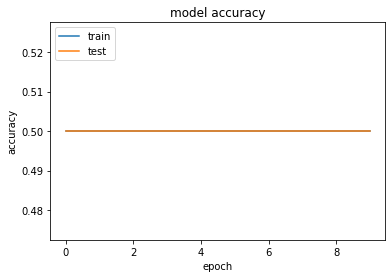

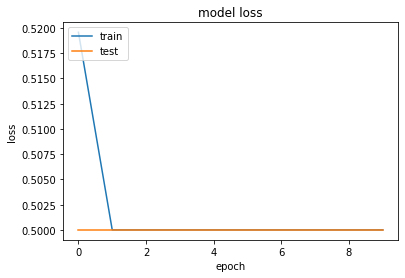

In [28]:
train_label_cat = to_categorical(train_label, 2)
validation_label_cat = to_categorical(validation_label, 2)

model = Sequential()
model.add(keras.layers.Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer = 'adam',  loss="mean_squared_error",  metrics=['accuracy'])
history = model.fit(train_data, train_label_cat, 
                    validation_data=(validation_data, validation_label_cat), epochs= 10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

2 types de résultats :
Predict validation -> -1.0 : 48 of 150 / 1.0 : 130 of 150
Predict train -> -1.0 : 265 of 800 / 1.0 : 715 of 800
ou
Predict validation -> -1.0 : 150 of 150 / 1.0 : 0 of 150
Predict train -> -1.0 : 800 of 800 / 1.0 : 0 of 800

In [29]:
linear = Linear(dll_path)
linear.init_linear_model(((frequency_max * 2) // frequency_precision) * 2)
linear.train_linear_model_classification(train_data.flatten(), train_label.flatten(), len(train_label), 20000, 0.3)

good_predict, number_of_predict = test_linear(validation_data, validation_label)
#print("predicted result : " + str(predicted_value) + " / result : " + str(validation_label[i]))
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test_linear(train_data, train_label)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

Test :
Predict of -1.0 : 37 of 200
Predict of 1.0 : 194 of 200
Train :
Predict of -1.0 : 151 of 800
Predict of 1.0 : 791 of 800


## MLP

### Keras

Epoch 1/20
38/38 [==============================] - 2s 54ms/step - loss: 0.5160 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 57ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 46ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.4998 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 46ms/step - loss: 0.4186 - accuracy: 0.5000 - val_loss: 0.2549 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 56ms/step - loss: 0.2538 - accuracy: 0.5000 - val_loss: 0.2504 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 50ms/step - loss: 0.2501 - accuracy: 0.5000 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 58ms/step - loss: 0.2500 - accuracy: 0.5000 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 8/20
38

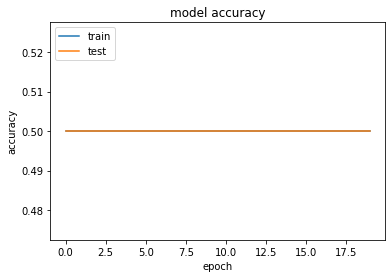

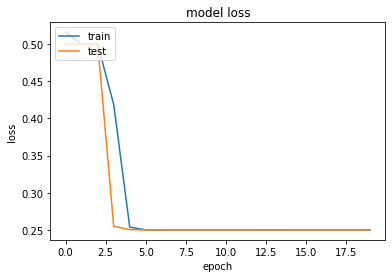

[0.49942446] / 1.0
[0.49878657] / 1.0
[0.49907228] / 1.0
[0.49908084] / 1.0
[0.49943146] / 1.0
[0.49907237] / -1.0
[0.49876767] / 1.0
[0.49902448] / 1.0
[0.49907276] / -1.0
[0.5002508] / 1.0
[0.50003535] / -1.0
[0.49972916] / -1.0
[0.4999405] / -1.0
[0.4989822] / 1.0
[0.50003153] / 1.0
[0.49962634] / 1.0
[0.4992216] / 1.0
[0.49874422] / 1.0
[0.50003654] / -1.0
[0.49971965] / -1.0
[0.49941504] / 1.0
[0.49941534] / -1.0
[0.49876517] / -1.0
[0.4990722] / -1.0
[0.49971965] / -1.0
[0.49941504] / -1.0
[0.49941567] / 1.0
[0.5002508] / -1.0
[0.49922925] / 1.0
[0.49921647] / -1.0
[0.49900627] / 1.0
[0.49895346] / -1.0
[0.49907073] / 1.0
[0.49937707] / 1.0
[0.49906865] / -1.0
[0.49988765] / 1.0
[0.4990722] / -1.0
[0.49907237] / -1.0
[0.49978292] / 1.0
[0.49876404] / 1.0
[0.49928105] / 1.0
[0.49895254] / -1.0
[0.49903062] / -1.0
[0.4993682] / 1.0
[0.49922362] / 1.0
[0.4987998] / -1.0
[0.49908084] / -1.0
[0.49889827] / 1.0
[0.49889827] / -1.0
[0.49874422] / -1.0
[0.49899042] / -1.0
[0.49953914] / 

In [9]:
train_label_cat = to_categorical(train_label, 2)
validation_label_cat = to_categorical(validation_label, 2)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_data.shape[1:]),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])

model.compile(optimizer = 'adam',  loss='mean_squared_error',  metrics=['accuracy'])
history = model.fit(train_data, train_label_cat, 
                    validation_data=(validation_data, validation_label_cat), epochs= 20)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


prediction = model.predict(validation_data)
for i in range(len(prediction)):
    print(str(prediction[i]) + " / " + str(validation_label[i]))

### Lib Rust

predict -1 -> 340 sur 340
predict 1 -> 0 sur 334

In [20]:
last_couche = 2

mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2], 64, 64, last_couche], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 100.0, 0.2)

good_predict, number_of_predict = test_mlp(mlp, validation_data, validation_label, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 0]
[340, 0, 334]


## 3 Classes

## MLP

In [29]:
number_of_label = 3
train_max_by_label = 600
val_max_by_label = 100
train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, val_max_by_label)

print("Import Finish")
print(train_data.shape)
print(train_label.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

Import Finish
(1800, 8000, 2)
(1800,)


### Keras

Bloque a 33%

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2048128   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 2,065,027
Trainable params: 2,065,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
57/57 [==============================] - 2s 34ms/step - loss: 1.1170 - accuracy: 0.3361 - val_loss: 1.2033 - val_accuracy: 0.3333
Epoch 2/20
57/57 [==============================] - 2s 32ms/step - loss: 1.1331 - accuracy: 0.3222 - 

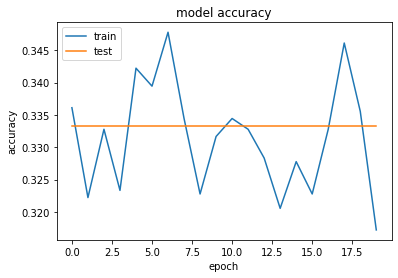

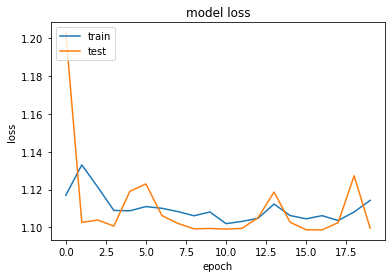

In [30]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_data.shape[1:]),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_label, validation_data=(validation_data, validation_label), epochs=20)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

Prédit toujours la même classe comme avec Keras

In [27]:
last_couche = 3

mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2], 128, 128, last_couche], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 1000.0, 0.03)

good_predict, number_of_predict = test_mlp(mlp, validation_data, validation_label, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 12, 0]
[0, 12, 12, 14]


# Spectrogram

In [7]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import sys

sys.path.append('../Lib/PythonML')
from linear import Linear
from multicouche import MLP
from rbf import RBF 
from tensorflow import keras
from random import randrange

In [8]:
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
train_path = '../Dataset/Train/Spectrogram'
validation_path = '../Dataset/Test/Spectrogram'

In [9]:
def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def test(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            print(predicted_value)
            if label[i] < 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

def test_rbf(model, data, label):
    good_predict = [0, 0]
    number_of_predict = [0, 0]
    for i in range(len(data)):
        predicted_value = model.predict_rbf_model(data[i])    
        if label[i] < 0:
            number_of_predict[0] += 1
            if predicted_value < 0.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value >= 0.0:
                good_predict[1] += 1
                
    return (good_predict, number_of_predict)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

## 2 Classes

In [10]:
class_names = ['piano', 'saxo'] # 'guitare'
max_data_by_label = 1500
max_val_by_label = 300
IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [11]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(3000, 32, 32, 3)
(3000,)


### MLP

### Keras

Epoch 97/100
loss: 0.5981 - accuracy: 0.6867 - val_loss: 0.6500 - val_accuracy: 0.6359

Epoch 1/100
94/94 [==============================] - 5s 55ms/step - loss: 0.6995 - accuracy: 0.5163 - val_loss: 0.6898 - val_accuracy: 0.5233
Epoch 2/100
94/94 [==============================] - 7s 74ms/step - loss: 0.6930 - accuracy: 0.5107 - val_loss: 0.6923 - val_accuracy: 0.5517
Epoch 3/100
94/94 [==============================] - 7s 74ms/step - loss: 0.6917 - accuracy: 0.5250 - val_loss: 0.6856 - val_accuracy: 0.5483
Epoch 4/100
94/94 [==============================] - 6s 60ms/step - loss: 0.6872 - accuracy: 0.5507 - val_loss: 0.6830 - val_accuracy: 0.5533
Epoch 5/100
94/94 [==============================] - 6s 64ms/step - loss: 0.6865 - accuracy: 0.5490 - val_loss: 0.6843 - val_accuracy: 0.5550
Epoch 6/100
94/94 [==============================] - 5s 53ms/step - loss: 0.6865 - accuracy: 0.5443 - val_loss: 0.6832 - val_accuracy: 0.5667
Epoch 7/100
94/94 [==============================] - 6s 60ms/step - loss: 0.6826 - accuracy: 0.5583 - val_loss: 0.6785 - val_accuracy: 0.5850
Epoch 

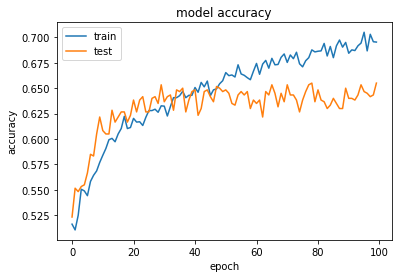

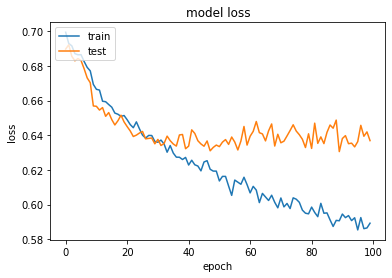

In [9]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #over-fitting
    keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Prédit toujours la même classe

In [85]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='tanh')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
94/94 [==============================] - 1s 13ms/step - loss: 0.3089 - accuracy: 0.5063 - val_loss: 0.2563 - val_accuracy: 0.5000
Epoch 2/100
94/94 [==============================] - 1s 14ms/step - loss: 0.2579 - accuracy: 0.5043 - val_loss: 0.2531 - val_accuracy: 0.5050
Epoch 3/100
94/94 [==============================] - 1s 13ms/step - loss: 0.2533 - accuracy: 0.5197 - val_loss: 0.2500 - val_accuracy: 0.5100
Epoch 4/100
94/94 [==============================] - 2s 20ms/step - loss: 0.2501 - accuracy: 0.5237 - val_loss: 0.2561 - val_accuracy: 0.5000
Epoch 5/100
94/94 [==============================] - 2s 16ms/step - loss: 0.2506 - accuracy: 0.5257 - val_loss: 0.2472 - val_accuracy: 0.5433
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 0.2500 - accuracy: 0.5307 - val_loss: 0.2468 - val_accuracy: 0.5483
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 0.2502 - accuracy: 0.5360 - val_loss: 0.2468 - val_accuracy: 0.5517
Epoch 8/

KeyboardInterrupt: 

### Lib Rust

In [12]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                if i == 0:
                    train_labels.append(-1)
                else:
                    train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                if i == 0:
                    validation_labels.append(-1)
                else:
                    validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(3000, 32, 32, 3)
(3000,)


#### MLP

Prédit toujours la même classe

In [98]:
last_couche = 2
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 128, 32, 32, 8, last_couche], dtype='float64'))
mlp.output_function = mlp.ActivationFunction.Relu

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)


good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 0]
[300, 0, 300]


#### RBF

In [ ]:
rbf = RBF(dll_path)
rbf.train_rbf_model(train_images, train_labels, 1000.0)
rbf.save_model("../App/interfacev2/Models/rbf_one_vs_one/piano_saxo.txt")

good_predict, number_of_predict = test_rbf(rbf, validation_images, validation_labels)
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test_rbf(rbf, train_images, train_labels)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

## 3 Classes

In [75]:
class_names = ['piano', 'saxo','guitare']
max_data_by_label = 1500
max_val_by_label = 250
IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [76]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(4500, 32, 32, 3)
(4500,)


### Keras

1500 données en 32x32
1er modèle
    Epoch 6/100
    loss: 1.0381 - accuracy: 0.4764 - val_loss: 1.0947 - val_accuracy: 0.4854
2eme modèle
    Epoch 32/100
    loss: 0.9734 - accuracy: 0.5533 - val_loss: 0.9948 - val_accuracy: 0.5365
    Epoch 78/100
    loss: 0.9271 - accuracy: 0.6113 - val_loss: 0.9801 - val_accuracy: 0.5431

Epoch 1/80
141/141 [==============================] - 7s 53ms/step - loss: 1.0996 - accuracy: 0.3358 - val_loss: 1.0941 - val_accuracy: 0.3787
Epoch 2/80
141/141 [==============================] - 7s 52ms/step - loss: 1.0934 - accuracy: 0.3696 - val_loss: 1.0909 - val_accuracy: 0.3827
Epoch 3/80
141/141 [==============================] - 8s 60ms/step - loss: 1.0906 - accuracy: 0.3820 - val_loss: 1.0917 - val_accuracy: 0.3773
Epoch 4/80
141/141 [==============================] - 9s 62ms/step - loss: 1.0871 - accuracy: 0.3851 - val_loss: 1.0916 - val_accuracy: 0.3707
Epoch 5/80
141/141 [==============================] - 10s 68ms/step - loss: 1.0875 - accuracy: 0.3676 - val_loss: 1.0892 - val_accuracy: 0.3907
Epoch 6/80
141/141 [==============================] - 10s 73ms/step - loss: 1.0840 - accuracy: 0.3942 - val_loss: 1.0887 - val_accuracy: 0.4133
Epoch 7/80
141/141 [==============================] - 8s 56ms/step - loss: 1.0796 - accuracy: 0.4129 - val_loss: 1.0772 - val_accuracy: 0.42

Epoch 58/80
141/141 [==============================] - 9s 62ms/step - loss: 0.9397 - accuracy: 0.5916 - val_loss: 1.0095 - val_accuracy: 0.5093
Epoch 59/80
141/141 [==============================] - 7s 51ms/step - loss: 0.9372 - accuracy: 0.5951 - val_loss: 1.0151 - val_accuracy: 0.5147
Epoch 60/80
141/141 [==============================] - 6s 40ms/step - loss: 0.9321 - accuracy: 0.6013 - val_loss: 1.0252 - val_accuracy: 0.4973
Epoch 61/80
141/141 [==============================] - 7s 52ms/step - loss: 0.9322 - accuracy: 0.5996 - val_loss: 1.0063 - val_accuracy: 0.5240
Epoch 62/80
141/141 [==============================] - 6s 43ms/step - loss: 0.9342 - accuracy: 0.5960 - val_loss: 1.0068 - val_accuracy: 0.5133
Epoch 63/80
141/141 [==============================] - 8s 55ms/step - loss: 0.9296 - accuracy: 0.6096 - val_loss: 1.0144 - val_accuracy: 0.5173
Epoch 64/80
141/141 [==============================] - 9s 62ms/step - loss: 0.9336 - accuracy: 0.6022 - val_loss: 1.0149 - val_accuracy:

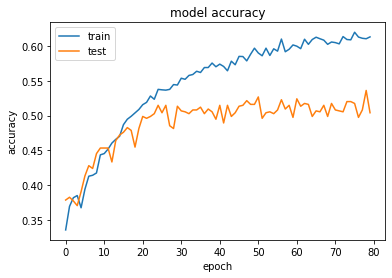

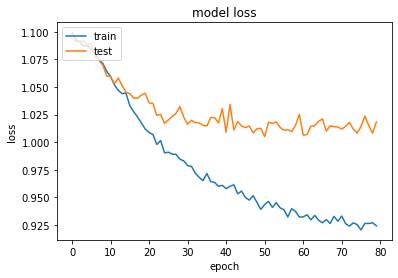

In [13]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #over-fitting
    keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=80)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(3, activation='tanh')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
141/141 [==============================] - 2s 14ms/step - loss: 0.6924 - accuracy: 0.3344 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 0.6667 - accuracy: 0.3373 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 4/100
141/141 [==============================] - 1s 10ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 5/100
141/141 [==============================] - 3s 22ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 6/100
117/141 [=======================>......] - ETA: 0s - loss: 0.6683 - accuracy: 0.3365

KeyboardInterrupt: 

### Lib Rust

In [33]:
last_couche = 3
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 256, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Relu

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)


good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 320, 0]
[0, 320, 320, 320]


# Spectrogram Studio (light)

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import sys

sys.path.append('../Lib/PythonML')
from linear import Linear
from multicouche import MLP
from rbf import RBF 
from tensorflow import keras
from random import randrange

In [2]:
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
#train_path = '/home/losabit/Desktop/dataset_light/spectro/'
#validation_path = '../Dataset/Test/Spectrogram'
#train_path = '/home/losabit/Desktop/dataset_light/train_val/train'
#validation_path = '/home/losabit/Desktop/dataset_light/train_val/validation'
train_path = '../Dataset/Train/Spectrogram_light'
validation_path = '../Dataset/Test/Spectrogram_light'

## 2 Classes

In [3]:
class_names = ['piano', 'saxo']# 'guitare'
max_data_by_label = 450
max_val_by_label = 50

IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [4]:
def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def test(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            print(predicted_value)
            if label[i] < 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

def test_rbf(model, data, label):
    good_predict = [0, 0]
    number_of_predict = [0, 0]
    for i in range(len(data)):
        predicted_value = model.predict_rbf_model(data[i])    
        if label[i] < 0:
            number_of_predict[0] += 1
            if predicted_value < 0.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value >= 0.0:
                good_predict[1] += 1
                
    return (good_predict, number_of_predict)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

In [104]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
    
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(900, 32, 32, 3)
(900,)


### Keras

Epoch 10/100
loss: 0.6771 - accuracy: 0.5889 - val_loss: 0.6585 - val_accuracy: 0.6300

Epoch 1/100
29/29 [==============================] - 2s 55ms/step - loss: 0.7326 - accuracy: 0.4900 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
29/29 [==============================] - 1s 45ms/step - loss: 0.6933 - accuracy: 0.5100 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 3/100
29/29 [==============================] - 2s 56ms/step - loss: 0.6909 - accuracy: 0.5400 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 2s 62ms/step - loss: 0.6867 - accuracy: 0.5411 - val_loss: 0.6835 - val_accuracy: 0.5200
Epoch 5/100
29/29 [==============================] - 2s 56ms/step - loss: 0.6970 - accuracy: 0.4989 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 6/100
29/29 [==============================] - 2s 68ms/step - loss: 0.6902 - accuracy: 0.5189 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/100
29/29 [==============================] - 2s 73ms/step - loss: 0.6849 - accuracy: 0.5644 - val_loss: 0.6853 - val_accuracy: 0.5800
Epoch 

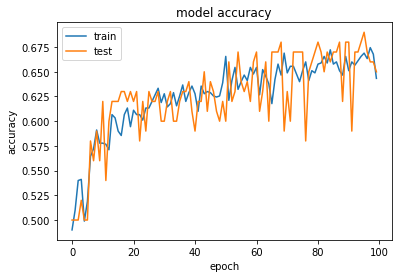

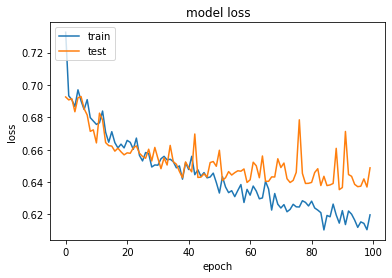

In [24]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3093 - accuracy: 0.2800 - val_loss: 0.2689 - val_accuracy: 0.5000
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.2616 - accuracy: 0.2067 - val_loss: 0.2552 - val_accuracy: 0.0000e+00
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 0.2608 - accuracy: 0.1789 - val_loss: 0.3161 - val_accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.2922 - accuracy: 0.2222 - val_loss: 0.2471 - val_accuracy: 0.5000
Epoch 5/100
29/29 [==============================] - 0s 11ms/step - loss: 0.2634 - accuracy: 0.2511 - val_loss: 0.2767 - val_accuracy: 0.0000e+00
Epoch 6/100
29/29 [==============================] - 0s 8ms/step - loss: 0.2602 - accuracy: 0.3544 - val_loss: 0.2376 - val_accuracy: 0.0600
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.2478 - accuracy: 0.3211 - val_loss: 0.2525 - val_accuracy: 0.4600


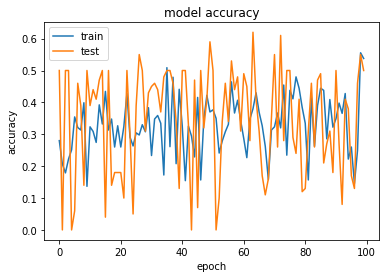

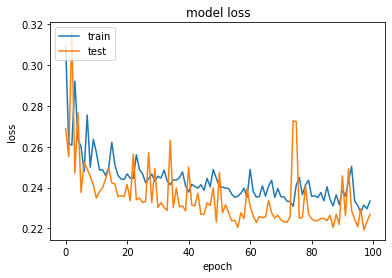

In [105]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(3, activation='tanh')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

In [5]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                if i == 0:
                    train_labels.append(-1)
                else:
                    train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                if i == 0:
                    validation_labels.append(-1)
                else:
                    validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(900, 32, 32, 3)
(900,)


#### RBF

In [6]:
rbf = RBF(dll_path)
rbf.train_rbf_model(train_images, train_labels, 100000.0)
rbf.save_model("../App/interfacev2/Models/rbf_one_vs_one/guitare_saxo.txt")
good_predict, number_of_predict = test_rbf(rbf, validation_images, validation_labels)
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test_rbf(rbf, train_images, train_labels)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

Test :
Predict of -1.0 : 26 of 50
Predict of 1.0 : 31 of 50
Train :
Predict of -1.0 : 216 of 450
Predict of 1.0 : 226 of 450


### 3 classes

In [39]:
class_names = ['piano', 'saxo', 'guitare']
max_data_by_label = 500
max_val_by_label = 50

IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [40]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
    
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(1500, 32, 32, 3)
(1500,)


### Keras

Epoch 50/50
loss: 0.9748 - accuracy: 0.5600 - val_loss: 0.9937 - val_accuracy: 0.5467

Epoch 1/100
47/47 [==============================] - 3s 63ms/step - loss: 1.1007 - accuracy: 0.3640 - val_loss: 1.0952 - val_accuracy: 0.4000
Epoch 2/100
47/47 [==============================] - 3s 61ms/step - loss: 1.0846 - accuracy: 0.4167 - val_loss: 1.0904 - val_accuracy: 0.4067
Epoch 3/100
47/47 [==============================] - 3s 56ms/step - loss: 1.0810 - accuracy: 0.4267 - val_loss: 1.0825 - val_accuracy: 0.4000
Epoch 4/100
47/47 [==============================] - 3s 57ms/step - loss: 1.0692 - accuracy: 0.4387 - val_loss: 1.0933 - val_accuracy: 0.3867
Epoch 5/100
47/47 [==============================] - 3s 65ms/step - loss: 1.0656 - accuracy: 0.4360 - val_loss: 1.0867 - val_accuracy: 0.4067
Epoch 6/100
47/47 [==============================] - 3s 69ms/step - loss: 1.0663 - accuracy: 0.4400 - val_loss: 1.0889 - val_accuracy: 0.4000
Epoch 7/100
47/47 [==============================] - 3s 68ms/step - loss: 1.0636 - accuracy: 0.4340 - val_loss: 1.1107 - val_accuracy: 0.3933
Epoch 

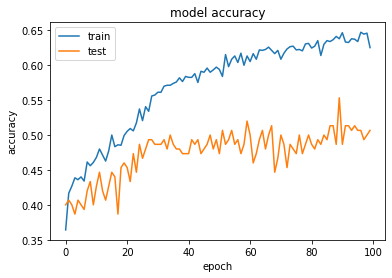

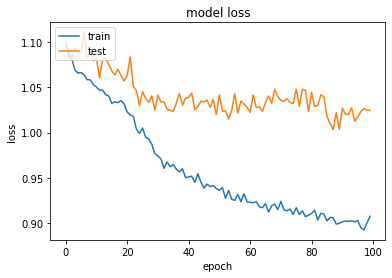

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

In [7]:
last_couche = 3
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 64, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Tanh

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)
mlp.save_model("../App/interfacev2/Models/mlp.txt")

good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 50, 0]
[0, 50, 50, 50]
